In [43]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy as sp
import scipy.stats as stats
import seaborn as sns
import copy
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, recall_score, roc_curve, precision_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier 
from sklearn.tree import DecisionTreeClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import plotly.express as px
from IPython.display import display

# DTSA 5509 Final Project Loan Default Prediction
### Author: Wei Yu (David) Wang
### Date: 2023-10-16

## Introduction and Problem Description

For my final project for DTSA-5509, I decided to take on the August 2023 Coursera Data Science Coding Challenge: Loan Default Prediction. I wanted to apply the knowledge I learned in this course to real-life financial data and gain the knowledge to solve real-life issues such as risk management in potential loan defaults. 

The types of learning algorithms and types of tasks to classify if a loan is likely to go to default include
- Polynomial Regression
- Logistic Regression
- Decision Tree
- Random Forest
- Adaboost
- Support Vector Classification (SVC)
- and a Neural Work using Keras. 

Before running this notebook, please ensure that all dependacies listed above are installed. Thank you for taking the time to view my work!

## Data

The data is obtained from https://www.kaggle.com/datasets/nikhil1e9/loan-default. This Kaggel user obtained the data frame Coursera which provided a dataset that is a sample of individuals who received loans in 2021. 

Data Science Coding Challenge: Loan Default Prediction (no date) Coursera. Available at: https://www.coursera.org/projects/data-science-coding-challenge-loan-default-prediction (Accessed: 16 October 2023). 

While I do know that a good portion of data science work is data cleaning, I wanted to skip ahead and jump into the machine learning with a fairly clean dataset. There are 18 attributes, ranging from the debtor's age, income, credit score to if they have a cosigner or a mortgage. The targetted attribute to classify is the Default attribute which is if the loan eventually defaulted or not. This is a large dataset 255347 rows of loans. The data format is tabulated data housed within a single csv file. 

In [44]:
# loading the dataset
df = pd.read_csv("https://raw.githubusercontent.com/davidwangweiyu/DTSA5509/main/Loan_default.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

In [45]:
# Shape of Dataset
df.shape

(255347, 18)

## Data Cleaning and Exploratory Data Analysis (EDA) Procedure

### Data Cleaning

The steps to clean and process the data include loading in the dataset, identifying the data types of variables in the csv, identifying attributes that cannot be encoded into ordered numerical values, and encoding object variables to numerical values.

The goal of the data cleaning process is to create a dataframe fit for machine learning by converting all values into integers or floats. This is done by using df.info() to determine if there are null values and the data type of each variable. Then for all variables with object datatype, df['variable'].unique() is used to determine if the values can be ordered or binary classified. In this case, non of the variables with more than 2 unique values could be ordered because either domain knowledge is required or a whole seperate machine learning analysis is needed to determine how the values should be ordered in terms of default risk.

For example for marital status, how should single, married and divorced be ordered? Should it go single > married > divorced because you need to be married to divorce or married > single > divorced because married people are staying commited while divorced people broke a comittment to marriage and are thus more likely to break a comittment to a loan. 

#### Removing and Encoding Variables

From the info() function, it can be seen that Education, Marital Status, Has Mortgage, Has Dependents, Loan Purpose, Has Cosigner are object datatypes. There are no null values as seen in the non-null count column, and there are over 250000 loan samples. For the attributes that are objects, work is needed to label encode the values for machine learning.

In [46]:
# Education Attribute
df['Education'].unique()

array(["Bachelor's", "Master's", 'High School', 'PhD'], dtype=object)

In [47]:
# Employment Type
df['EmploymentType'].unique()

array(['Full-time', 'Unemployed', 'Self-employed', 'Part-time'],
      dtype=object)

In [48]:
# Marital Status
df['MaritalStatus'].unique()

array(['Divorced', 'Married', 'Single'], dtype=object)

In [49]:
# Loan Purpose
df['LoanPurpose'].unique()

array(['Other', 'Auto', 'Business', 'Home', 'Education'], dtype=object)

This is iterated for all object data type variables. 

For simplicity, any non-binary classification of attributes including Education, Employment Type, Marital Status, and Loan Purpose were removed and not encoded because further analysis is required to order the categories or very complicating interaction terms are required. 

For example, to determine the order if a Bachelor's or a Master's educated person is more likely to default requires domain knowledge or a much deeper analysis into the dataset because an undergrad student might make less money but also have less debt.

Object datatypes that can be classified into binary is encoded and kept below.

In [50]:
# If the debtor has a mortgage
df['HasMortgage'].unique()

array(['Yes', 'No'], dtype=object)

In [51]:
label_encoder = LabelEncoder()
df['HasMortgage_enc'] = label_encoder.fit_transform(df['HasMortgage'])
df['HasMortgage_enc'].unique()

array([1, 0])

In [52]:
# If the debtor has dependents
df['HasDependents'].unique()

array(['Yes', 'No'], dtype=object)

In [53]:
label_encoder = LabelEncoder()
df['HasDependents_enc'] = label_encoder.fit_transform(df['HasDependents'])
df['HasDependents_enc'].unique()

array([1, 0])

In [54]:
# If the debor has a cosigner
df['HasCoSigner'].unique()

array(['Yes', 'No'], dtype=object)

In [55]:
label_encoder = LabelEncoder()
df['HasCoSigner_enc'] = label_encoder.fit_transform(df['HasCoSigner'])
df['HasCoSigner_enc'].unique()

array([1, 0])

In [56]:
# Remove all object datatype columns (LoanID should be used for machine learning) 
columns_to_remove = ['LoanID', 'Education', 'EmploymentType', 'MaritalStatus', 'LoanPurpose',
                     'HasMortgage', 'HasDependents', 'EmploymentType', 'HasCoSigner', 'LoanPurpose']

df.drop(columns_to_remove, axis=1, inplace=True)

In [57]:
# Put Default as the first column because it is the targetted attribute for classification
first_column = 'Default'

# Ensure the column exists in the DataFrame
if first_column in df:
    # Get the list of column names
    columns = df.columns.tolist()

    # Move the 'Default' column to the front
    columns.remove(first_column)
    columns = [first_column] + columns

    # Reorder the DataFrame columns
    df = df[columns]
else:
    print(f"'{first_column}' column not found in the DataFrame.")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Default            255347 non-null  int64  
 1   Age                255347 non-null  int64  
 2   Income             255347 non-null  int64  
 3   LoanAmount         255347 non-null  int64  
 4   CreditScore        255347 non-null  int64  
 5   MonthsEmployed     255347 non-null  int64  
 6   NumCreditLines     255347 non-null  int64  
 7   InterestRate       255347 non-null  float64
 8   LoanTerm           255347 non-null  int64  
 9   DTIRatio           255347 non-null  float64
 10  HasMortgage_enc    255347 non-null  int32  
 11  HasDependents_enc  255347 non-null  int32  
 12  HasCoSigner_enc    255347 non-null  int32  
dtypes: float64(2), int32(3), int64(8)
memory usage: 22.4 MB


It can now be seen that there are no object data type columns and the entire dataset can be used for machine learning. 

### EDA

In [58]:
# Generating a Correlation Matrix
df.corr()

,Default,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,HasMortgage_enc,HasDependents_enc,HasCoSigner_enc
Default,1.000000,-0.167783,-0.099119,0.086659,-0.034166,-0.097374,0.028330,0.131273,0.000545,0.019236,-0.022856,-0.034678,-0.039109
Age,-0.167783,1.000000,-0.001244,-0.002213,-0.000548,-0.000341,-0.000890,-0.001127,0.000263,-0.004689,0.000035,0.000710,-0.002918
Income,-0.099119,-0.001244,1.000000,-0.000865,-0.001430,0.002675,-0.002016,-0.002303,-0.000998,0.000205,-0.000945,-0.001570,-0.003524
LoanAmount,0.086659,-0.002213,-0.000865,1.000000,0.001261,0.002817,0.000794,-0.002291,0.002538,0.001122,-0.000801,0.000139,-0.001848
CreditScore,-0.034166,-0.000548,-0.001430,0.001261,1.000000,0.000613,0.000016,0.000436,0.001130,-0.001039,0.001728,-0.003018,-0.002755
MonthsEmployed,-0.097374,-0.000341,0.002675,0.002817,0.000613,1.000000,0.001267,0.000096,-0.001166,0.001765,0.000210,0.001450,0.001045
NumCreditLines,0.028330,-0.000890,-0.002016,0.000794,0.000016,0.001267,1.000000,-0.000297,-0.000226,-0.000586,-0.001744,-0.001895,0.002105
InterestRate,0.131273,-0.001127,-0.002303,-0.002291,0.000436,0.000096,-0.000297,1.000000,0.000892,0.000575,-0.000424,-0.000243,-0.003991
LoanTerm,0.000545,0.000263,-0.000998,0.002538,0.001130,-0.001166,-0.000226,0.000892,1.000000,0.002273,0.001775,0.002417,-0.001166
DTIRatio,0.019236,-0.004689,0.000205,0.001122,-0.001039,0.001765,-0.000586,0.000575,0.002273,1.000000,0.000231,0.001492,0.000373


<AxesSubplot:>

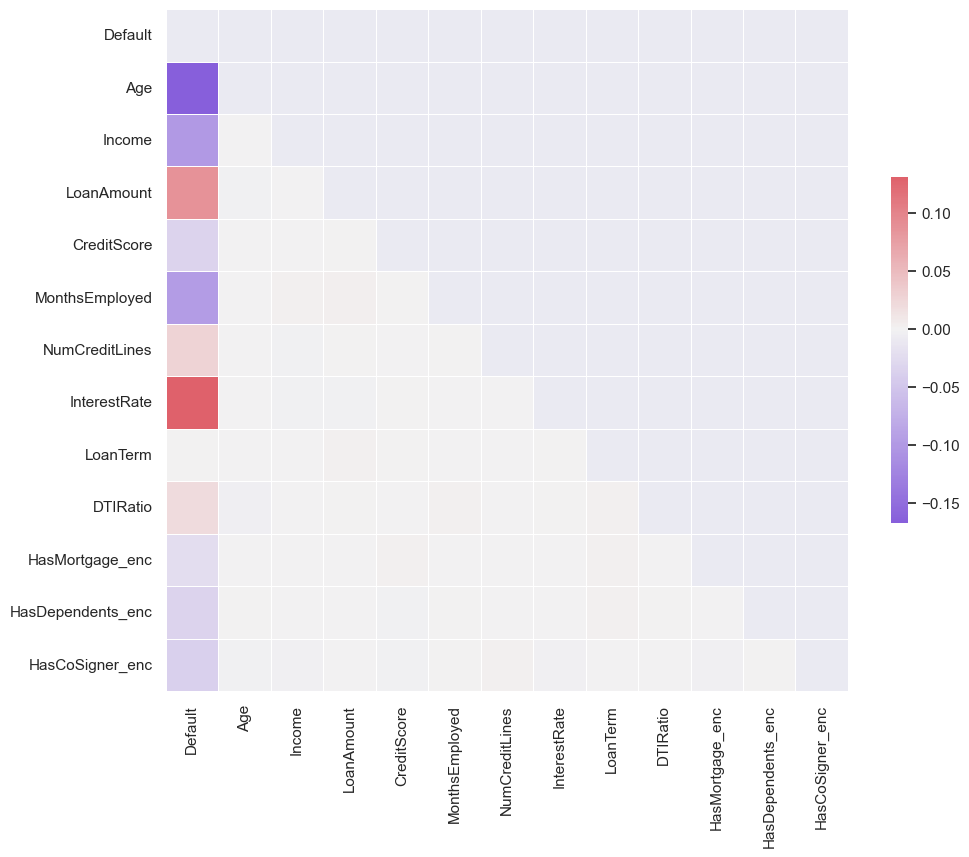

In [59]:
# Generating a Heatmap of the Correlation Matrix

sns.set()
corr = df.corr()
msk = np.triu(np.ones_like(corr, dtype=bool))
(f, ax) = plt.subplots(figsize=(11, 9))
color_map = sns.diverging_palette(275, 10, as_cmap=True)
sns.heatmap(corr, mask = msk, cmap = color_map, center=0, square =True, linewidths=.5, cbar_kws={"shrink": .5})

In [60]:
# Number of Defaulted Loans vs Non Defaulted Loans
defaulted = df[df['Default'] == 1]
not_defaulted = df[df['Default'] == 0]

defaulted.shape[0], not_defaulted.shape[0]

(29653, 225694)

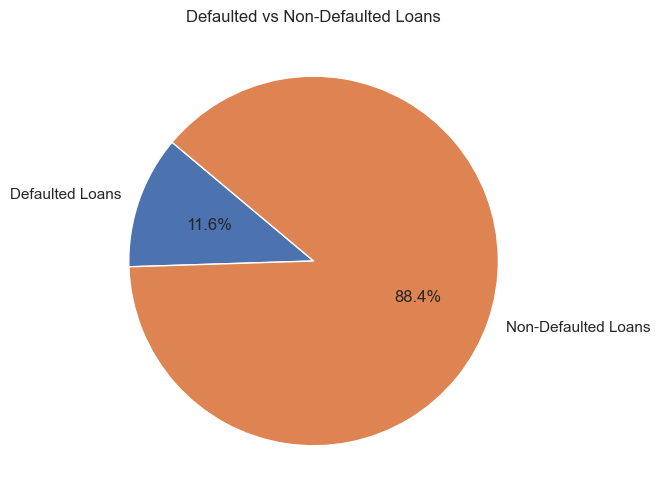

In [61]:
labels = ['Defaulted Loans', 'Non-Defaulted Loans']  # Labels for the two values
values = [defaulted.shape[0], not_defaulted.shape[0]]

# Create a pie chart
plt.figure(figsize=(6, 6))  # Set the figure size
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=140)  # Create the pie chart

# title
plt.title('Defaulted vs Non-Defaulted Loans')

# Display pie chart
plt.show()

From the heatmap and correlation matrix, it can be seen that the risk of default is negatively correlated with age, months employed, and income while positively correlated with interest rate, loan amount, and debt to income ratio. However, the scores are all very low with age at -0.167783, indicating that a simple regression model will perform poorly. Generally, all variables are not correlated and not colinear. By identifying that 88.4% of loans are non-default, a baseline model can be created for comparison. Any model created should at least be able to beat a precision score of 0.884 with a recall score of 1 and an f1 score of 0.938 or else it's worse than a model that determines every loan will not default. 

## Analysis and Model Building

### Polynomial Regression

The first model tested is the polynomial regression method. A backward optimization was used below.

In [62]:
# Creating a formula from a list of columns
column_names = df.columns.tolist()

factor_columns = column_names[2:]
formula_ols = 'Default ~ '

for factor in factor_columns:
    if formula_ols == 'Default ~ ':
        formula_ols += factor
    else:
        formula_ols = formula_ols + " + " + factor

print(formula_ols)

Default ~ Income + LoanAmount + CreditScore + MonthsEmployed + NumCreditLines + InterestRate + LoanTerm + DTIRatio + HasMortgage_enc + HasDependents_enc + HasCoSigner_enc


In [63]:
# Polynomial Regression Model Building
model = smf.ols(formula_ols, data = df).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                Default   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     1212.
Date:                Tue, 17 Oct 2023   Prob (F-statistic):               0.00
Time:                        00:25:16   Log-Likelihood:                -65176.
No. Observations:              255347   AIC:                         1.304e+05
Df Residuals:                  255335   BIC:                         1.305e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.1383      0.00

The results of this model is very poor with an R-Squared value of 0.05. Loan Term needs to be removed because its P Value is over 0.05

In [64]:
# Removing Loan Term
modified_formula = formula_ols.replace("+ LoanTerm ", '')
model1 = smf.ols(modified_formula, data = df).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                Default   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     1333.
Date:                Tue, 17 Oct 2023   Prob (F-statistic):               0.00
Time:                        00:25:16   Log-Likelihood:                -65176.
No. Observations:              255347   AIC:                         1.304e+05
Df Residuals:                  255336   BIC:                         1.305e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.1383      0.00

After removing all variables with a P value over 0.05, the model still performs just as poorly. It looks like this method is unsuitable for predicting if a loan will go into default. This could be that Polynomial regression is intended to predict continuous numeric values and not a binary classifier as needed for this ML problem.

### Logistic Regression

The next ML method used is logistic regression, which is primarily used for classification problems, where the goal is to predict binary or multiclass outcomes (e.g., yes/no, spam/ham, or class labels).

The dataset used is split into training and testing data for validating ML model metrics.

In [65]:
# Splitting into training and testing datasets

x = df.drop('Default', axis=1)
y = df['Default']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state = 0)

In [66]:
# Creating a Logistic Regression Model

LogReg = LogisticRegression().fit(x_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [67]:
# Make predictions on the test set
y_pred = LogReg.predict(x_test)

# Calculate precision and recall
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the results
print("Precision:", precision)
print("Recall:", recall)

Precision: 0.6694214876033058
Recall: 0.0108


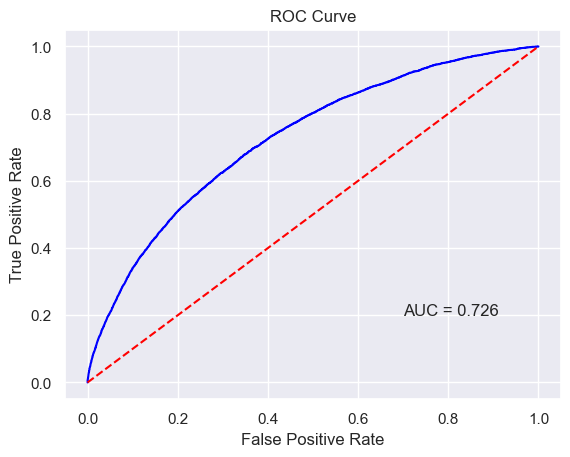

In [68]:
ypredprob = LogReg.predict_proba(x_test)
roc_auc = round(roc_auc_score(y_test, ypredprob[:, 1]), 4)
fpr, tpr, th = roc_curve(y_test, ypredprob[:, 1])
plt.plot(fpr, tpr, color = "blue")
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), color = "red", linestyle = "dashed")
plt.text(x = 0.7, y = 0.2, s = "AUC = " + str(roc_auc))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

From the precision and recall metrics, it looks like the logistic regression method is also a poor choice for this problem as the model is not even able to recall 0.05% of loan defaults. This is likely because the model has a linear decision boundary which is problematic if the relationship between predictors and the outcome is nonlinear which occurs in this case as seen from the correlation matrix.

## Decision Tree Classifier

The next ML method to test is the decision tree method which can model complex, nonlinear relationships in the data.
Three decision tree methods are going to be used including a 
- default decision tree classifier
- random forest
- adaboost classifier

### Default decision tree classifier

In [69]:
# Initialize and train a decision tree classifier
decision_tree = DecisionTreeClassifier()
decision_tree.fit(x_train, y_train)

# Make predictions on the test set
y_pred_dt = decision_tree.predict(x_test)

# Evaluate the decision tree model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)
classification_report_dt = classification_report(y_test, y_pred_dt)

print("Decision Tree Classifier Results:")
print(f"Accuracy: {accuracy_dt}")
print("Confusion Matrix:\n", conf_matrix_dt)
print("Classification Report:\n", classification_report_dt)

Decision Tree Classifier Results:
Accuracy: 0.802919936713818
Confusion Matrix:
 [[49518  6819]
 [ 5762  1738]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89     56337
           1       0.20      0.23      0.22      7500

    accuracy                           0.80     63837
   macro avg       0.55      0.56      0.55     63837
weighted avg       0.81      0.80      0.81     63837



From the classification report, it looks like a default decision tree performs significantly better than logistic regression increasing the recall of defaults to ~23%. However, the model is still very unreliable with a precision score of ~20% for defaults.

### Random Forest

In [70]:
# Initialize and train a random forest classifier
random_forest = RandomForestClassifier()
random_forest.fit(x_train, y_train)

# Make predictions on the test set
y_pred_rf = random_forest.predict(x_test)

# Evaluate the random forest model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
classification_report_rf = classification_report(y_test, y_pred_rf)

print("\nRandom Forest Classifier Results:")
print(f"Accuracy: {accuracy_rf}")
print("Confusion Matrix:\n", conf_matrix_rf)
print("Classification Report:\n", classification_report_rf)


Random Forest Classifier Results:
Accuracy: 0.884173755032348
Confusion Matrix:
 [[56087   250]
 [ 7144   356]]
Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94     56337
           1       0.59      0.05      0.09      7500

    accuracy                           0.88     63837
   macro avg       0.74      0.52      0.51     63837
weighted avg       0.85      0.88      0.84     63837



From the classification report, it looks like the random forest performs worse than the default decision tree classifier, being able to only recall ~5% of defaults but increaing the precision of predicting defaults to ~59%.

### AdaBoost Classifier

In [71]:
# Initialize and train a decision tree and adaboost classifier
base_classifier = DecisionTreeClassifier()
adaboost_model = AdaBoostClassifier(base_classifier, n_estimators=50)
adaboost_model.fit(x_train, y_train)

# Make predictions on the test set
y_pred = adaboost_model.predict(x_test)

# Evaluate the AdaBoost model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("AdaBoost Classifier Results:")
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", report)

AdaBoost Classifier Results:
Accuracy: 0.8023873302316838
Confusion Matrix:
 [[49520  6817]
 [ 5798  1702]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89     56337
           1       0.20      0.23      0.21      7500

    accuracy                           0.80     63837
   macro avg       0.55      0.55      0.55     63837
weighted avg       0.81      0.80      0.81     63837



From the classification report, it looks like the Adaboost classifier performs very similar to the default decision tree classifier.

While the adaboost forest method is an improvment from logistic regression and polynomial regression, a ~23% recall rate of loan defaults is still very unreliable.

## Neural Network

Neural networks are highly flexible and can learn complex non-linear relationships in the data. Because they consist of multiple layers of interconnected neurons, they can model intricate patterns. The method used in this analysis is a sequential keras model. The sequential model builds neural networks in a sequential, layer by layer method.

The first layers added are set at Rectified Linear Unit (relu) which is one if the most popular activation functions and is computationally efficient. The second layer added are set at sigmoid activation which squashes the output to the range of 0 - 1 and is commonly used in binary classification problems. 

In [106]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Set a random seed for TensorFlow
np.random.seed(0)
tf.random.set_seed(0)

# Normalizing features
X = (x - x.mean()) / x.std()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0)

# Initializing Keras Sequential Model

model = keras.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dense(1, activation='sigmoid'))

# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fitting the model to the training datset
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

# Creating predictions for validation
y_pred = model.predict(X_test)
# Classifying forecast values so that values greater than 0.5 counts as a default (1), 
# and values less than 0.5 counts as not at risk for default (0)
y_pred = (y_pred > 0.5)

# Example for classification
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(accuracy)
print(precision)
print(recall)
print(f1)
print(conf_matrix)
print(report)

Epoch 1/10
5387/5387 [==============================] - 5s 857us/step - loss: 0.3233 - accuracy: 0.8831 - val_loss: 0.3169 - val_accuracy: 0.8867
Epoch 2/10
5387/5387 [==============================] - 5s 877us/step - loss: 0.3161 - accuracy: 0.8857 - val_loss: 0.3144 - val_accuracy: 0.8865
Epoch 3/10
5387/5387 [==============================] - 5s 894us/step - loss: 0.3152 - accuracy: 0.8858 - val_loss: 0.3142 - val_accuracy: 0.8859
Epoch 4/10
5387/5387 [==============================] - 4s 821us/step - loss: 0.3149 - accuracy: 0.8860 - val_loss: 0.3140 - val_accuracy: 0.8862
Epoch 5/10
5387/5387 [==============================] - 4s 822us/step - loss: 0.3145 - accuracy: 0.8863 - val_loss: 0.3137 - val_accuracy: 0.8874
Epoch 6/10
5387/5387 [==============================] - 4s 821us/step - loss: 0.3143 - accuracy: 0.8861 - val_loss: 0.3134 - val_accuracy: 0.8865
Epoch 7/10
5387/5387 [==============================] - 4s 823us/step - loss: 0.3141 - accuracy: 0.8865 - val_loss: 0.3130 -

From first glance, this model looks poor being only able to recall 3% of loan defaults and performs very similarily to the random forest classifier. 

However, the user is able to set "y_pred = (y_pred > 0.5)" at a different level than 0.5. 
Values between 0 to 0.8 in increments of 0.005 will be tested in order to maximize the recall of loan defaults while minimizing loss of recall for loans that do not default.

In [107]:
# Testing values 0 - 0.8 in increments of 0.005 in order to classify if a loan will default. 

zero_recall = []
one_recall = []

zero_precision = []
one_precision = []

zero_f1 = []
one_f1 = []

true_negative = []
false_negative = []

weighted_avg = []
y_pred_set = []


for i in range(0, 161):
    print(str(i/200))
    y_pred = model.predict(X_test)
    y_pred = (y_pred > i/200)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    zero_recall += [report['0']['recall']]
    one_recall += [report['1']['recall']]
    zero_precision += [report['0']['precision']]
    one_precision += [report['1']['precision']]
    zero_f1 += [report['0']['f1-score']]
    one_f1 += [report['1']['f1-score']]
    true_negative += [conf_matrix[0][0]]
    false_negative += [conf_matrix[1][0]]
    weighted_avg += [report['weighted avg']['f1-score']]
    y_pred_set += [i/200]

dtf_lis = {'Default Score': y_pred_set, 'Recall 0': zero_recall, 
           'Recall 1': one_recall, 'Precision 0': zero_precision, 
           'Precision 1': one_precision, 'F1 0': zero_f1, 'F1 1': one_f1,
          'True Negative': true_negative, 'False Negative': false_negative,
          'Weighted Average F1': weighted_avg}

dtf = pd.DataFrame(dtf_lis)

0.0
1995/1995 [==============================] - 1s 561us/step
0.005
 183/1995 [=>............................] - ETA: 1s

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



1995/1995 [==============================] - 1s 556us/step
0.01
1995/1995 [==============================] - 1s 559us/step
0.015
1995/1995 [==============================] - 1s 555us/step
0.02
1995/1995 [==============================] - 1s 560us/step
0.025
1995/1995 [==============================] - 1s 557us/step
0.03
1995/1995 [==============================] - 1s 559us/step
0.035
1995/1995 [==============================] - 1s 563us/step
0.04
1995/1995 [==============================] - 1s 556us/step
0.045
1995/1995 [==============================] - 1s 558us/step
0.05
1995/1995 [==============================] - 1s 558us/step
0.055
1995/1995 [==============================] - 1s 553us/step
0.06
1995/1995 [==============================] - 1s 563us/step
0.065
1995/1995 [==============================] - 1s 554us/step
0.07
1995/1995 [==============================] - 1s 556us/step
0.075
1995/1995 [==============================] - 1s 553us/step
0.08
1995/1995 [======================

In [108]:
len(y_pred)

63837

In [114]:
# Average Interest Rate

df['InterestRate'].mean()

13.492773480792886

In [115]:
# Profit Maximization
dtf['Gross'] = dtf['True Negative'] * 1.135 - dtf['False Negative']


max_cf1 = dtf['Gross'].max()
max_value_row = dtf[dtf['Gross'] == max_cf1]
max_value_row

,Default Score,Recall 0,Recall 1,Precision 0,Precision 1,F1 0,F1 1,True Negative,False Negative,Weighted Average F1,Gross
117,0.585,0.997621,0.0352,0.885938,0.663317,0.938468,0.066852,56203,7236,0.836065,56554.405


In [116]:
# Macro F1 Score Maximization

max_cf1 = dtf['Weighted Average F1'].max()
max_value_row = dtf[dtf['Weighted Average F1'] == max_cf1]
max_value_row

,Default Score,Recall 0,Recall 1,Precision 0,Precision 1,F1 0,F1 1,True Negative,False Negative,Weighted Average F1,Gross
67,0.335,0.960878,0.2132,0.901706,0.420458,0.930352,0.282934,54133,5901,0.854289,55539.955


In [118]:
# Greater than 50% Recall of Defaulted Loans
max_value_row = dtf[dtf['Default Score'] == 0.18]
max_value_row

,Default Score,Recall 0,Recall 1,Precision 0,Precision 1,F1 0,F1 1,True Negative,False Negative,Weighted Average F1,Gross
36,0.18,0.828958,0.508533,0.926846,0.283569,0.875173,0.364105,46701,3686,0.81513,49319.635


By testing values from 0 - 0.8 for the potential default score, the user is able to prioritize the model to a desired precision and recall score. 

For example, by setting the default score to 0.175, the model is able recall ~50% of loan defaults while still being able to recall ~83% of non-defaulting loans. This is where the F1 score for loan defaults (1) peaks.

At setting the default score at ~0.335 which is the maximum weighted F1 score for both classes, the model is able to recall ~28% of loan defaults at ~42% precision while still being able to recall ~96% of non-defaulting loans at ~90% precision.

Gross revenue is calculated with by calculating the true negative * the mean interest rate - the false negative. The maximum gross revenue occurs with the default score at 0.585.


## Results and Analysis

These results are very good because the innate nature of loans is that lendors make money on the risk of lending money. Their goals is to make more money charging interest on active loans than to lose on loan defaults. The best performing model is the neural network created using Keras Sequential. 

The key advantage of this model is that lendors can assess their own risk tolerance and set an appropriate default score depending on the current situation.

If there was unlimited access to credit for the lendor, they set a default score no higher than 0.585 for the goal of optimizing gross revenue from loans assuming loan amounts and interest rates are the same in the training and testing dataset which is highly likely in a dataset with over 255000 rows separated into 75% training and 25% testing. Revenue is calculated using the total true negative value (loans given that do not default) * the interest rate - total false negative value (loans given that do default).

However, very rarely do lendors have access to unlimited credit. A default score of ~0.335 calculated by obtaining the maximum weighted F1 score results in the best performing model. The weighted average F1 score considers class specific performance and class imbalance which is directly applicable here due to there being significantly less loan defaults than loans not defaulting. This choice does represent a ~2% loss of gross revenue compared to the choice above but the advantage is that compared to the default score above the lendor only needs to lend out ~94.6% of the capital (calculated by True Negative + False Negative for the default score of 0.585 - True Negative + False Negative for the default score of 0.335).

If the lendor wanted a recall rate greater than 50% for loans that default, a default score less than ~0.18 should be set. This choice does represent a significant ~13% loss of gross revenue compared to the gross revenue driven model but requires only ~79% of capital.

In [112]:
# Plotting the Results
fig = px.line(dtf, x='Default Score', y=['Gross', 'True Negative', 'False Negative'], title='Gross Revenue vs Set Default Score')
display(fig)

In [117]:
# Plotting the Results
fig = px.line(dtf, x='Default Score', y=['Recall 0', 'Recall 1', 'Precision 0', 'Precision 1', 'F1 0', 'F1 1', 'Weighted Average F1'], title='% Precision and Recall vs Set Default Score')
display(fig)

## Discussion and Conclusion

### Learning and Takeaways
This project focussed on assessing the different methods of ML in predicting if a loan will default. Selecting the correct model is important because performance, precision, and recall varies dramatically. For this use-case and dataset, it was determined that the Keras Sequential model was the best choice due to the ability to the sigmoid activation layer outputting classification values between 0,1 allowing for the user to set a custom score classification score. I was able to set three different scores optimizing the results for different use-cases such as profit maximization, weighted f1 score maximization, and requiring recall rates for default to be greater than 50%.

### Where things can go wrong
I had to set a random seed for the keras model because the model was not consistent in outputting results especially for the profit driven use-case. I have gotten values from ~0.5 - ~0.68. From the Gross Revenue vs Score chart, it can be seen that the gross revenue plateaus between 0.4 and 0.8. If banks were using this method to give out loans and they started at the model optimizing default score of 0.335 and realized that they could make more money by increasing the default score (lowering requirements), maybe that's how banking crises happen where new loans default en masse and the banks cannot cover these losses with what they make on interest payments on the non-defaulting loans.

### Ways to Improve
The attributes education, employment type, and marital status was removed because they could not be ordered for machine learning. If they could be ordered, the model could gain more insight from these variables.

Another way to improve the model is to create seperate models depending on loan purposes. These loan purposes are very different from one another. The average interest rate was 13.5% for the dataset which from my personal experiences for US loans in 2021 is well above the mortgage rates of ~4% with the prime rate at 3.5%